<a href="https://colab.research.google.com/github/frankyeung1996/Tutorial-Python-Data-Science/blob/master/tensorflow_basic_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tf-nightly

     |████████████████████████████████| 322.8MB 49kB/s 
     |████████████████████████████████| 460kB 46.7MB/s 
     |████████████████████████████████| 6.8MB 46.2MB/s 


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
print(tf.__version__)

2.4.0-dev20200716


In [17]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                    untar=True, cache_dir='/content/',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

dataset_dir

6053888/6053168 [==============================] - 0s 0us/step


'/content/stack_overflow_16k'

In [18]:
os.listdir(dataset_dir)

['train', 'test']

In [19]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'javascript', 'csharp', 'java']

In [21]:
sample_file = os.path.join(train_dir, 'csharp/0.txt')
with open(sample_file) as f:
  print(f.read())

"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much 

In [23]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [24]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [25]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to csharp
Label 1 corresponds to java


In [26]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [27]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/train', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [28]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [29]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [30]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [31]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [32]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

In [33]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [34]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
embedding_dim = 16

In [40]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [45]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 1.3802 - accuracy: 0.3345 - val_loss: 1.3714 - val_accuracy: 0.4450
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 1.3568 - accuracy: 0.4539 - val_loss: 1.3393 - val_accuracy: 0.5462
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 1.3119 - accuracy: 0.5383 - val_loss: 1.2858 - val_accuracy: 0.5888
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 1.2468 - accuracy: 0.6131 - val_loss: 1.2160 - val_accuracy: 0.6513
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 1.1701 - accuracy: 0.6658 - val_loss: 1.1377 - val_accuracy: 0.6888
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0870 - accuracy: 0.7002 - val_loss: 1.0604 - val_accuracy: 0.7256
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 1.0085 - accuracy: 0.7339 - val_loss: 0.9901 - val_accuracy: 0.7437
Epoch 

In [46]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.7937 - accuracy: 0.7931
Loss:  0.7936703562736511
Accuracy:  0.7931249737739563


In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

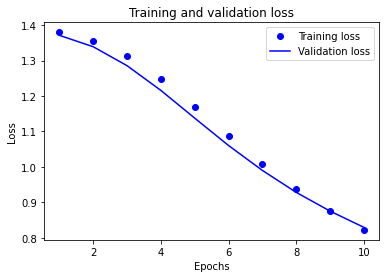

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

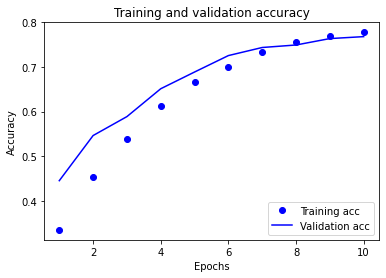

In [53]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [55]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 1.0741 - accuracy: 0.7931
0.7931249737739563
